# Classification of Ads
Purpose of this project is to classify Advertisements into sub categories (Accounting Finance jobs, Lawyer jobs, Apartment for Sale etc) based on the Ad description (text). This is an NLP use case. Dataset is ingested, pre-processed for NLP and further trained on classification models. 

#### Model Evaluation:
In terms of evaluation metric, "f1-score" is used as the metric as this being a harmoized view of Recall & Precision, is suitable for this multi-class classification. This is because there is no special significance for identification a particular class (unlike use cases such as Fraud detection or Disease detection). 

In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from nltk.util import ngrams
import nltk, re, string, collections

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer ,TfidfTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data = pd.read_csv(r"C:\Users\HP\Documents\DataScience\Python Scripts\Ads Classification\ads_en_us.csv")

## A look at the data
Initial analyis of data is done. Dataset has about 97k records. There are some duplicates in 'value' i.e duplicate documents. 

#### Class Imbalance
SubcatId distribution is not balanced - some sub-categories (eg subcatId 27) have higher representation than others. Hence there is 'class imbalance' in the dataset. But class imbalance is not extereme (say for example as in the case of Credit Card Fraud dataset). 

In this version of the mini-project, no special handling is done for this class imbalance issue. In the next version of this mini-project, tweaks to handle this will be shown. 


In [3]:
data.head()

,Unnamed: 0,catid,id,subcatid,value
0,0,2,45493,27,Overview \r\n \r\nWhy AFFIRMA Rehabilitation? ...
1,1,2,45499,27,Overview \r\n \r\nWhy AFFIRMA Rehabilitation? ...
2,2,2,45522,27,Overview:\r\n\r\nUnder general supervision by ...
3,3,2,45543,134,Be your own boss working under a Strong Brand ...
4,4,2,45545,134,Be your own boss working under a Strong Brand ...


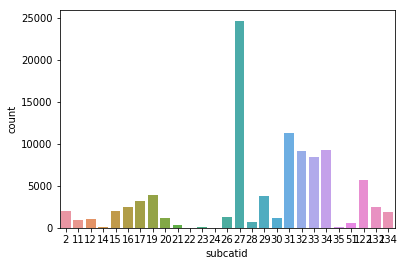

In [4]:
ax = sns.countplot(x="subcatid", data=data)
plt.show()

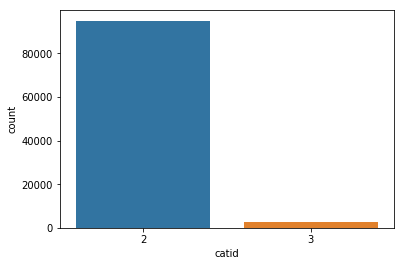

In [6]:
ax = sns.countplot(x="catid", data=data)
plt.show()

In [5]:
data_dup = data.groupby(data.value).size().reset_index().rename(columns={0:'count'})
data_dup.sort_values('count', ascending=False, inplace=True)
len(data_dup.loc[data_dup['count'] > 500, :])

8

In [10]:
data_s1 = data.sample(frac=.2)

In [11]:
data_s1.shape

(19520, 5)

In [13]:
data_s1.isnull().any().any()

False

## Pre-Processing
Remove Stopwords & punctuation, Convert to lower case, Spell correct and Lemmatize. Pre-processing commands used here have lesser code-print. Textblob has been used for lemmatization. nltk can as well be used.
Also analyzed are common and rare words. Certain synoyms are replaced basis this analysis.
Certain pre-processing tasks have been executed on a sample of this dataset for practicality. Full dataset is processed in AWS version. But models have been executed on full dataset.

In [14]:
#Pre-processing with full sample. 
stop = stopwords.words('english')
stop.append('The')
stop.append('This')
data_s1['value'] = data_s1['value'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data_s1['value'] = data_s1['value'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_s1['value'] = data_s1['value'].str.replace('[^\w\s]','')
data_s1['value'] = data_s1['value'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

#### Analyze Common and rare words

In [15]:
freq_1gram = pd.Series(' '.join(data_s1['value']).split()).value_counts()[:50] 
freq_1gram

team              43439
work              40203
experience        34605
service           32453
customer          28457
job               25936
care              23427
restaurant        22931
member            22839
shift             22591
position          22334
management        22147
company           21544
sale              19827
year              19518
skill             18544
we                18474
opportunity       17819
system            16674
business          16246
ability           15933
operation         15706
required          15554
patient           15494
support           15445
guest             15395
including         14267
program           13881
must              13868
responsibility    13857
information       13379
policy            13239
requirement       13114
procedure         12966
product           12667
a                 12487
professional      12408
training          12291
new               12060
need              11828
time              11702
manager         

#### Replace synonyms, similar words (contextual)
For this sample, Customer (28457 occurances) and Client (11376 occurances) are similar, hence 'Customer' is replaced with with 'Client'. 

In [16]:
data_s2 = data_s1
d={'customer':'client'}
d2 = {r'(\b){}(\b)'.format(k):r'\1{}\2'.format(v) for k,v in d.items()}
data_s2['value'] = data_s2['value'].replace(d2, regex=True)
freq_2gram = pd.Series(' '.join(data_s2['value']).split()).value_counts()[:50] 
freq_2gram

team              43439
work              40203
client            39833
experience        34605
service           32453
job               25936
care              23427
restaurant        22931
member            22839
shift             22591
position          22334
management        22147
company           21544
sale              19827
year              19518
skill             18544
we                18474
opportunity       17819
system            16674
business          16246
ability           15933
operation         15706
required          15554
patient           15494
support           15445
guest             15395
including         14267
program           13881
must              13868
responsibility    13857
information       13379
policy            13239
requirement       13114
procedure         12966
product           12667
a                 12487
professional      12408
training          12291
new               12060
need              11828
time              11702
manager         

#### Analyze top bigrams

In [17]:
word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(data_s2['value'])
frequencies = sum(sparse_matrix).data
#frequencies = sum(sparse_matrix).toarray()[0]
bigr_freq =pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [18]:
bigr_freq.sort_values(by=['frequency'], ascending=False)

,frequency
largest client,43439
latest hiv,40203
latest iteration,39833
large organization,34605
largest brand,32453
largest division,25936
language 4neuro,23427
land office,22931
launched 2009,22839
largesized enterpriseexcellent,22591


## Model 
TFIDF vector is used as feature set. Gridsearccv is done on Naivebayes (Multinomial & Bernoulli) and RandomForest. Accuracy and Classification Report is generated. Accuracy score of 82 & f1-score of 78 is obtained in RandomForest. Coresponding values for Naivebayes are slightly less. This is interesting as RF is generally not expected to do well in sparse high dimensional text data!. 

### Class Imbalance
Also the f1-scores of some classes very low - this is due to 'class imbalance' in the dataset. In this version of the mini-project, no special handling is done for this class imbalance issue. In the next version of this mini-project, tweaks to handle this will be shown. 


#### Naivebayes - Standalone Multinomial & OneVsRest with default Alpha

In [19]:
X = data_s2.value
y = data_s2.subcatid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 5)

In [37]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)

y1_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y1_pred, y_test))

accuracy 0.63120040652


In [25]:
y1_pred[:10]

array([ 31,  34,  31, 122,  34,  19,  33,  34,  27,  31], dtype=int64)

In [22]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', OneVsRestClassifier(MultinomialNB())),
              ])

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.647930266192


####  MultinomialNB and BernoulliNB in GridsearchCV with alpha grid 

In [48]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
random_grid = {
               'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001) 
              }
print(random_grid)
gs_clf_MulNB = GridSearchCV(nb, random_grid,cv=2)
gs_clf_MulNB.fit(X_train, y_train)
gs_clf_MulNB.best_params_
%%time
model = gs_clf_MulNB.best_estimator_
y_pred = model.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

In [20]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', BernoulliNB()),
              ])
random_grid = {
               'clf__alpha': (10, 1, 0.01, 0.001, 0.0001, 0.00001) 
              }
print(random_grid)
gs_clf_BerNB = GridSearchCV(nb, random_grid,cv=2)
gs_clf_BerNB.fit(X_train, y_train)
gs_clf_BerNB.best_params_
model = gs_clf_BerNB.best_estimator_
y_pred = model.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

{'clf__alpha': (10, 1, 0.01, 0.001, 0.0001, 1e-05)}

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)



accuracy 0.760245901639


In [23]:
print('accuracy %s' % confusion_matrix(y_pred, y_test))

accuracy [[ 111    0    0    0    0    0    0    0    0    0    0    0    0    1
     0    0    0    0    0    0    1    3    0   27    0    0    0]
 [   0   34    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    1    0    0    0    0    0]
 [   0    0   19    0    0    1    3    2    0    0    0    0    0    0
     3    1    0    0    0    0    0    2    0    0    1    1    5]
 [   0    0    0    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0   76    0    2    1    0    1    0    0    0    2
     1    0    1    0    0    2    6    2    0    0    6    0    1]
 [   0    4    2    0    2   86    0    8    0    2    0    0    1    2
     5    0    2    0    0   14    3    5    0    0    9    0    3]
 [   0    0    0    0    1    0  124    0    0    0    0    0    0    0
     0    0    2    0    0    0    0    1    0    0    6    0    0]
 [   0    0

In [24]:
print('accuracy %s' % classification_report(y_pred, y_test))

accuracy              precision    recall  f1-score   support

          2       0.97      0.78      0.86       143
         11       0.53      0.97      0.69        35
         12       0.28      0.50      0.36        38
         14       0.20      1.00      0.33         1
         15       0.59      0.75      0.66       102
         16       0.60      0.58      0.59       148
         17       0.67      0.93      0.78       134
         19       0.42      0.59      0.49       162
         20       0.64      0.58      0.61        91
         21       0.06      0.25      0.09         4
         22       0.00      0.00      0.00         0
         23       0.83      0.62      0.71         8
         24       0.50      1.00      0.67         1
         26       0.66      0.81      0.73        58
         27       0.97      0.94      0.95      1519
         28       0.76      0.70      0.73        46
         29       0.61      0.43      0.50       315
         30       0.42      0.92    

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


####  RandomForest in GridsearchCV with n_estimators & max_depth in random_grid

In [25]:
model = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_features='auto',bootstrap=False,random_state =42))])
random_grid = {'clf__n_estimators': (100, 200), 'clf__max_depth': (50, 100)}
gs_clf_rfc = GridSearchCV(model, random_grid,cv=2)
gs_clf_rfc.fit(X_train, y_train)
print(gs_clf_rfc.best_params_)
model = gs_clf_rfc.best_estimator_
y_pred = model.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


{'clf__max_depth': 100, 'clf__n_estimators': 200}
accuracy 0.765710382514


In [27]:
print('Classifiction Report %s' % classification_report(y_pred, y_test))

Classifiction Report              precision    recall  f1-score   support

          2       1.00      0.71      0.83       160
         11       0.47      1.00      0.64        30
         12       0.32      0.73      0.44        30
         14       0.20      1.00      0.33         1
         15       0.43      0.92      0.58        60
         16       0.39      0.68      0.50        82
         17       0.69      0.95      0.80       136
         19       0.50      0.79      0.61       143
         20       0.47      0.63      0.54        62
         21       0.06      0.33      0.10         3
         22       0.00      0.00      0.00         0
         23       0.67      1.00      0.80         4
         24       0.50      1.00      0.67         1
         26       0.65      0.92      0.76        50
         27       0.99      0.82      0.90      1758
         28       0.74      0.97      0.84        32
         29       0.51      0.68      0.59       165
         30       0.30  

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
